In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy
import pickle

import sys
import os

project_path = os.path.expanduser('~/repos/metric_graph/')
sys.path.append(project_path)

from construct_graph.graph import Graph, Flat
import construct_graph
from calculations.helper_functions import check_convergence

%load_ext autoreload
%autoreload 2

In [84]:
class Random_Delaunay:

    def __init__(self, num_Vs):

        self.num_Vs = num_Vs
        self.total_V_coords, self.total_num_Vs = self.construct_total_V_coords()
        self.total_edges = self.construct_total_edges()

        self.totally_periodic = False

    def construct_total_V_coords(self):

        num_Vs = 0
        bulk_V_coords = []
        boundary_V_coords = []
        while num_Vs < self.num_Vs:
            v_coords_x, v_coords_y = np.random.uniform(-15, 25, size=(2))
            v_coords = np.array([v_coords_x, v_coords_y])
            if (0 < v_coords_x < 1) and (0 < v_coords_y < 1):
                num_Vs += 1
                bulk_V_coords.append(v_coords)
            else:
                boundary_V_coords.append(v_coords)
        
        total_V_coords = np.vstack((bulk_V_coords, boundary_V_coords))
        total_num_Vs = total_V_coords.shape[0]

        return total_V_coords, total_num_Vs
    
    def construct_total_edges(self):

        triangulation = scipy.spatial.Delaunay(self.total_V_coords)
        V, W = triangulation.vertex_neighbor_vertices
        total_edges = []
        for v in range(self.total_num_Vs):
            w_inds = W[V[v]:V[v + 1]]
            for w in w_inds:
                if v < w:
                    total_edges.append([v, w])
        total_edges = np.array(total_edges)
        total_edges = np.sort(total_edges, axis=1)

        return total_edges

In [145]:
np.random.seed(0)
g = Random_Delaunay(50)

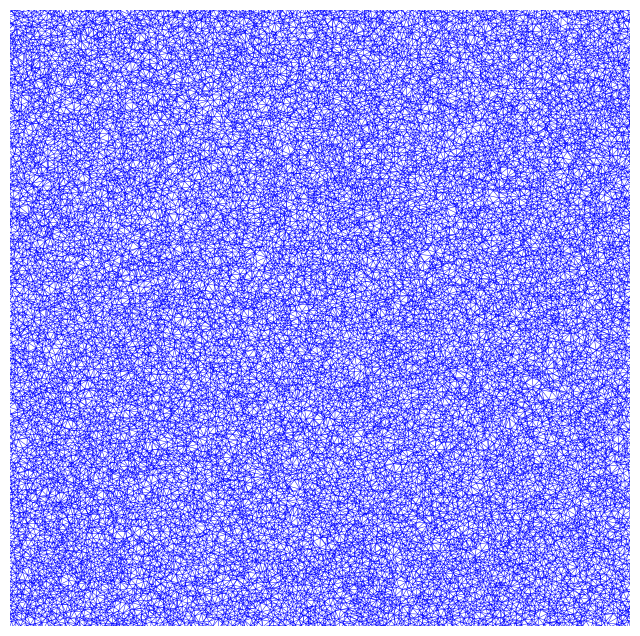

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for v, w in g.total_edges:
    line, = ax.plot(
        [g.total_V_coords[v][0], g.total_V_coords[w][0]],  
        [g.total_V_coords[v][1], g.total_V_coords[w][1]], 
        c='blue',
        linewidth=0.35 
    )
    line.set_solid_capstyle('round') 

ax.set_xlim(-8, 18)
ax.set_ylim(-8, 18)
ax.axis('off')

plt.savefig("../figures/delaunay/large_graph.png", dpi=300, bbox_inches="tight")

plt.show()


In [147]:
vertex_size = 30
edge_width = 1.1

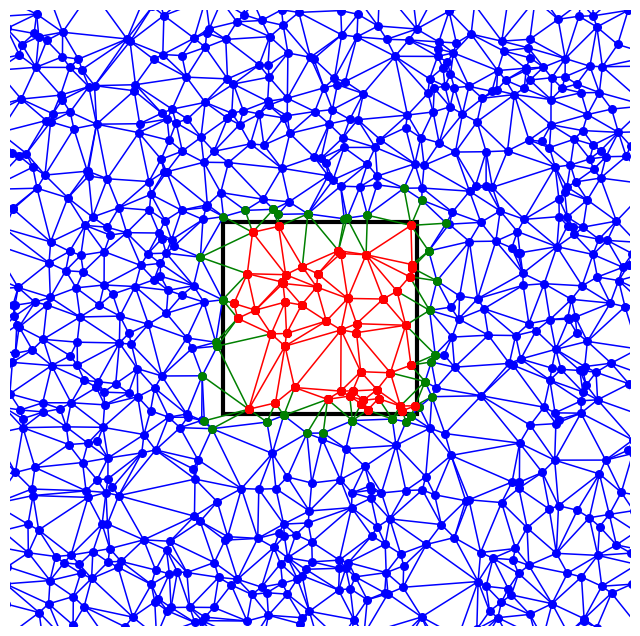

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(g.total_V_coords[:, 0], g.total_V_coords[:, 1], s=vertex_size, c="b", zorder=5)

for v, w in g.total_edges:
    v_coords = g.total_V_coords[v]
    w_coords = g.total_V_coords[w]

    v_in_box = (-2 < v_coords[0] < 3) and (-2 < v_coords[1] < 3)
    w_in_box = (-2 < w_coords[0] < 3) and (-2 < w_coords[1] < 3)

    if v_in_box and w_in_box:

        v_in_patch = v < g.num_Vs
        w_in_patch = w < g.num_Vs

        if (not v_in_patch) and (not w_in_patch):
            edge_color = 'b'
        elif v_in_patch and (not w_in_patch):
            edge_color = 'green'
            ax.scatter([v_coords[0]], [v_coords[1]], s=vertex_size, c="r", zorder=10)
            ax.scatter([w_coords[0]], [w_coords[1]], s=vertex_size, c="green", zorder=10)
        elif (not v_in_patch) and w_in_patch:
            edge_color = 'green'
            ax.scatter([w_coords[0]], [w_coords[1]], s=vertex_size, c="r", zorder=10)
            ax.scatter([v_coords[0]], [v_coords[1]], s=vertex_size, c="green", zorder=10)
        else:
            edge_color = 'r'
            ax.scatter([v_coords[0], w_coords[0]], [v_coords[1], w_coords[1]], s=vertex_size, c="r", zorder=10)

        line, = ax.plot([v_coords[0], w_coords[0]], [v_coords[1], w_coords[1]],  
            c=edge_color,
            zorder=1,
            linewidth=edge_width
        )
        line.set_solid_capstyle('round') 

square = patches.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor='none', linewidth=3, zorder=0)
ax.add_patch(square)

# for i in range(-2, 3):
#     ax.hlines(i, -2, 3, linewidth=3, color='black', alpha=0.6, linestyles="dashed", zorder=0)
#     ax.vlines(i, -2, 3, linewidth=3, color='black', alpha=0.6, linestyles="dashed", zorder=0)

ax.set_xlim(-1.1, 2.1)
ax.set_ylim(-1.1, 2.1)
ax.axis('off')

plt.savefig("../figures/delaunay/patch.png", dpi=300, bbox_inches="tight")

plt.show()

In [149]:
pg = construct_graph.patch_graph.Patch(g)

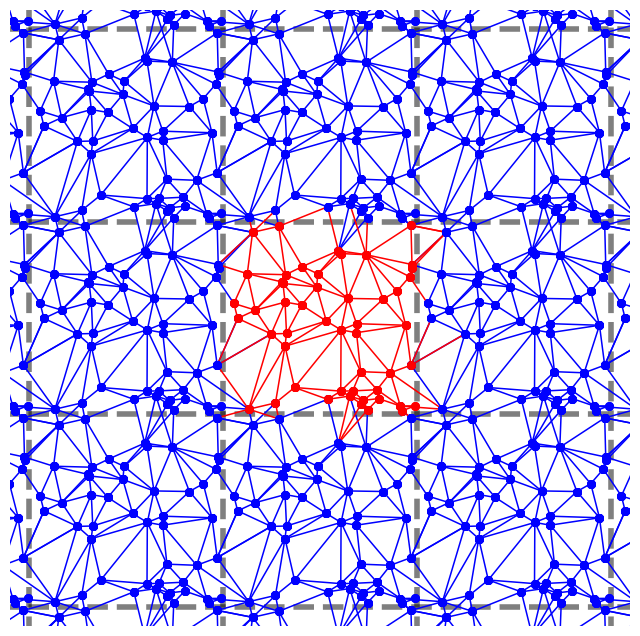

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# ax.scatter(pg.V_coords[:pg.num_Vs, 0], pg.V_coords[:pg.num_Vs, 1], s=50, c="b", zorder=5)

for i in range(-2, 3):
    for j in range(-2, 3):

        if (i == 0) and (j == 0):
            color = 'r'
            zorder = 10
        else:
            color = 'b'
            zorder = 5

        for edge in pg.periodic_edges:
            v, w = edge["vw"]
            v_coords, w_coords = edge["vw_coords"] + np.array([i, j])

            ax.scatter([v_coords[0], w_coords[0]], [v_coords[1], w_coords[1]], s=vertex_size, c='b', zorder=zorder)

            line, = ax.plot([v_coords[0], w_coords[0]], [v_coords[1], w_coords[1]],  
                c=color,
                zorder=zorder-1,
                linewidth=edge_width
            )
            line.set_solid_capstyle('round') 

        for edge in pg.bulk_edges:
            v, w = edge["vw"]
            v_coords, w_coords = edge["vw_coords"] + np.array([i, j])

            ax.scatter([v_coords[0], w_coords[0]], [v_coords[1], w_coords[1]], s=vertex_size, c=color, zorder=zorder)

            line, = ax.plot([v_coords[0], w_coords[0]], [v_coords[1], w_coords[1]],  
                c=color,
                zorder=zorder,
                linewidth=edge_width
            )
            line.set_solid_capstyle('round') 

# square = patches.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor='none', linewidth=3, zorder=0)
# ax.add_patch(square)

for i in range(-2, 3):
    ax.hlines(i, -2, 3, linewidth=4, color='black', alpha=0.5, linestyles="dashed", zorder=0)
    ax.vlines(i, -2, 3, linewidth=4, color='black', alpha=0.5, linestyles="dashed", zorder=0)

ax.set_xlim(-1.1, 2.1)
ax.set_ylim(-1.1, 2.1)
ax.axis('off')

plt.savefig("../figures/delaunay/periodized_patch.png", dpi=300, bbox_inches="tight")

plt.show()